In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 8.56k/8.56k [00:00<00:00, 4.36MB/s]

Extracting files...
Path to dataset files: C:\Users\AARYAMAN\.cache\kagglehub\datasets\fedesoriano\heart-failure-prediction\versions\1


Loading dataset from: C:\Users\AARYAMAN\.cache\kagglehub\datasets\fedesoriano\heart-failure-prediction\versions\1\heart.csv

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Shape: (918, 12)

Columns: ['Age', 'Sex', 'ChestPainType', 'Resting

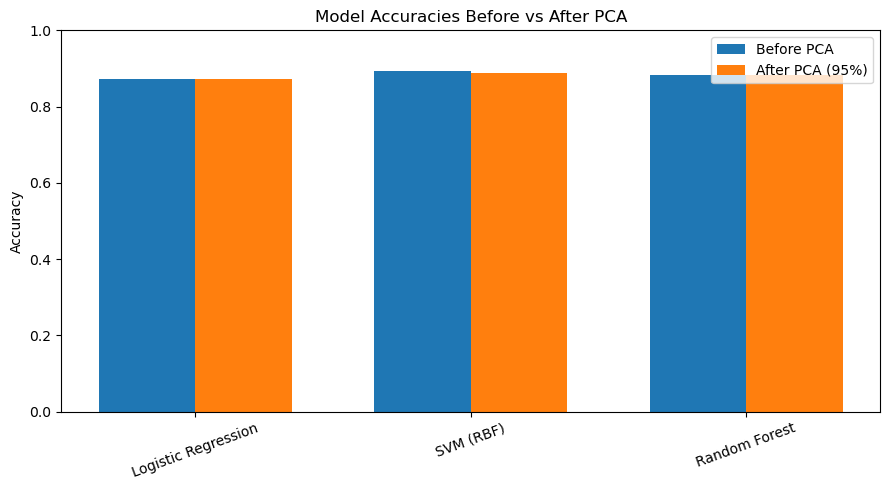


Saved accuracy comparison plot to: accuracy_before_after_pca.png


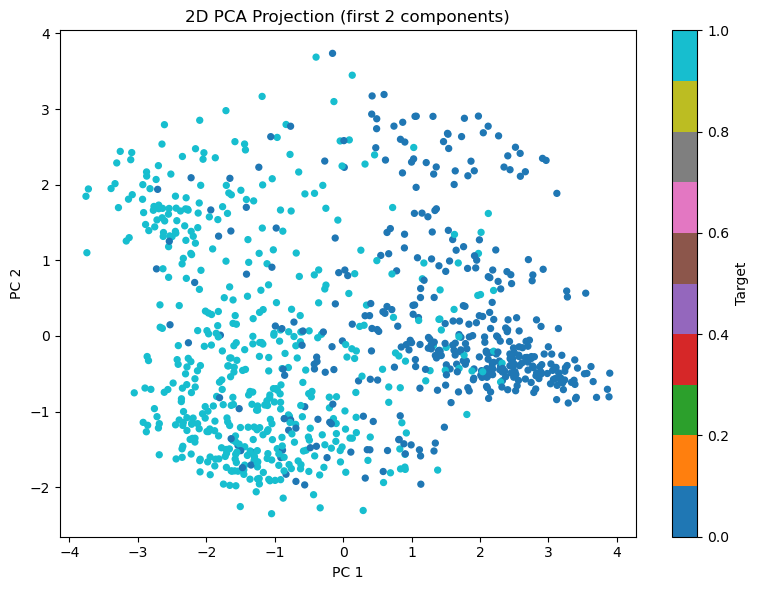

Saved 2D PCA scatter to: pca_2d_scatter.png

--- FINAL SUMMARY ---
Dataset path: C:\Users\AARYAMAN\.cache\kagglehub\datasets\fedesoriano\heart-failure-prediction\versions\1\heart.csv
Original shape: (918, 16)
Shape after outlier removal: (899, 16)
Target column used: HeartDisease

Accuracies BEFORE PCA:
  Logistic Regression      : 0.8722
  SVM (RBF)                : 0.8944
  Random Forest            : 0.8833
Accuracies AFTER PCA (95% variance):
  Logistic Regression      : 0.8722
  SVM (RBF)                : 0.8889
  Random Forest            : 0.8833

PCA components retained: 13
Total variance retained by PCA: 0.9719
Variance retained by 2 components: 0.3393

Notes:
- If 'Before' accuracies >> 'After', PCA possibly removed predictive signal.
- PCA typically reduces dimensionality & compute time; small accuracy drop is expected.
- Plots saved: accuracy_before_after_pca.png , pca_2d_scatter.png


In [8]:
# Final full pipeline for heart.csv — cleaned, plotted, and summarized
import os
os.environ["OMP_NUM_THREADS"] = "1"   # avoid MKL multi-thread warnings on Windows

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --------------------------
# Config / path
# --------------------------
csv_path = r"C:\Users\AARYAMAN\.cache\kagglehub\datasets\fedesoriano\heart-failure-prediction\versions\1\heart.csv"

# --------------------------
# Load dataset
# --------------------------
print("Loading dataset from:", csv_path)
df = pd.read_csv(csv_path)
print("\nFirst 5 rows:")
print(df.head())
print("\nShape:", df.shape)
print("\nColumns:", list(df.columns))

# --------------------------
# Detect target column
# --------------------------
possible_targets = ['target', 'HeartDisease', 'DEATH_EVENT', 'death', 'DEATH']
target_col = None
for name in possible_targets:
    if name in df.columns:
        target_col = name
        break
if target_col is None:
    target_col = df.columns[-1]
    print(f"\nNo common target name found. Assuming last column as target: '{target_col}'")
else:
    print(f"\nDetected target column: '{target_col}'")

print("\nTarget value counts:")
print(df[target_col].value_counts())

# --------------------------
# Basic cleaning
# --------------------------
# drop duplicates
before_shape = df.shape
df = df.drop_duplicates().reset_index(drop=True)
print(f"\nDropped duplicates: {before_shape} -> {df.shape}")

# --------------------------
# Categorical encoding (object/bool/category)
# --------------------------
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
print("\nCategorical columns detected:", cat_cols)
if cat_cols:
    # Use get_dummies for safety (one-hot); if too many unique values, label-encode fallback
    try:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
        print("Applied one-hot encoding to categorical columns.")
    except Exception as e:
        print("One-hot encoding failed, falling back to label encoding. Error:", e)
        le = LabelEncoder()
        for c in cat_cols:
            df[c] = le.fit_transform(df[c].astype(str))
        print("Applied label encoding to categorical columns.")
else:
    print("No categorical columns to encode.")

# --------------------------
# Numeric columns for outlier removal
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols_no_target = [c for c in numeric_cols if c != target_col]
else:
    numeric_cols_no_target = numeric_cols.copy()

print("\nNumeric columns considered for outlier removal:", numeric_cols_no_target)

# Robust numeric-only outlier removal using Z-score (|z| < 3 kept)
if len(numeric_cols_no_target) > 0:
    num_df = df[numeric_cols_no_target].copy()
    # fill numeric NaNs with numeric column means
    num_df = num_df.fillna(num_df.mean())
    # compute z-scores safely (ddof=0)
    z_scores = np.abs((num_df - num_df.mean()) / (num_df.std(ddof=0) + 1e-12))
    keep_mask = (z_scores < 3).all(axis=1)
    df_no_outliers = df.loc[keep_mask].reset_index(drop=True)
else:
    df_no_outliers = df.copy()

print("Shape before outlier removal:", df.shape)
print("Shape after outlier removal :", df_no_outliers.shape)

# --------------------------
# Prepare features (X) and labels (y)
# --------------------------
if target_col not in df_no_outliers.columns:
    # fallback: last column
    target_col = df_no_outliers.columns[-1]
    print("Adjusted target column to:", target_col)

X = df_no_outliers.drop(columns=[target_col])
y = df_no_outliers[target_col]

print("\nFinal feature matrix shape:", X.shape)
print("Target distribution after cleaning:")
print(y.value_counts())

# --------------------------
# Scaling
# --------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nFeatures scaled. Example (first row):", np.round(X_scaled[0,:5], 4))

# --------------------------
# Train/Test split BEFORE PCA (for baseline)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain/Test sizes (before PCA):", X_train.shape, X_test.shape)

# --------------------------
# Models to evaluate
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM (RBF)": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

# --------------------------
# Train & evaluate BEFORE PCA
# --------------------------
print("\n=== Model accuracies BEFORE PCA ===")
accuracies_before = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_before[name] = acc
    print(f"{name:25s}: {acc:.4f}")

# --------------------------
# PCA retaining 95% variance
# --------------------------
pca = PCA(0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
n_components = pca.n_components_
explained = np.sum(pca.explained_variance_ratio_)
print(f"\nPCA reduced features from {X_scaled.shape[1]} -> {n_components} components (retained variance = {explained:.4f})")
print("Explained variance ratio (first 10):", np.round(pca.explained_variance_ratio_[:10], 4))

# --------------------------
# Train/Test split AFTER PCA (95%)
# --------------------------
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# Train & evaluate AFTER PCA
# --------------------------
print("\n=== Model accuracies AFTER PCA (95% variance) ===")
accuracies_after = {}
for name, model in models.items():
    model.fit(X_train_pca, y_train_pca)
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test_pca, y_pred)
    accuracies_after[name] = acc
    print(f"{name:25s}: {acc:.4f}")

# --------------------------
# PCA with 2 components for visualization & variance info
# --------------------------
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
variance_2comp = np.sum(pca2.explained_variance_ratio_)
print(f"\nVariance retained by first 2 components: {variance_2comp:.4f}")

# Evaluate logistic regression using only 2 components (illustrative)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_pca2, y, test_size=0.2, random_state=42, stratify=y
)
lr_2 = LogisticRegression(max_iter=2000)
lr_2.fit(X_train_2, y_train_2)
acc_2comp = accuracy_score(y_test_2, lr_2.predict(X_test_2))
print(f"Logistic Regression accuracy with 2 PCA components: {acc_2comp:.4f}")

# --------------------------
# Plots: accuracy comparison and 2D PCA scatter
# --------------------------
labels = list(models.keys())
before_vals = [accuracies_before[m] for m in labels]
after_vals = [accuracies_after[m] for m in labels]

# Bar chart — before vs after PCA
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, before_vals, width, label='Before PCA')
plt.bar(x + width/2, after_vals, width, label='After PCA (95%)')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.xticks(x, labels, rotation=20)
plt.title('Model Accuracies Before vs After PCA')
plt.legend()
plt.tight_layout()
acc_plot_path = "accuracy_before_after_pca.png"
plt.savefig(acc_plot_path, dpi=150)
plt.show()
print(f"\nSaved accuracy comparison plot to: {acc_plot_path}")

# 2D PCA scatter (colored by target)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='tab10', s=18)
plt.colorbar(scatter, label='Target')
plt.title('2D PCA Projection (first 2 components)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
pca2_plot_path = "pca_2d_scatter.png"
plt.savefig(pca2_plot_path, dpi=150)
plt.show()
print(f"Saved 2D PCA scatter to: {pca2_plot_path}")

# --------------------------
# --------- Print final summary ----------
# --------------------------
print("\n--- FINAL SUMMARY ---")
print("Dataset path:", csv_path)
print("Original shape:", df.shape)
print("Shape after outlier removal:", df_no_outliers.shape)
print("Target column used:", target_col)
print("\nAccuracies BEFORE PCA:")
for k,v in accuracies_before.items():
    print(f"  {k:25s}: {v:.4f}")
print("Accuracies AFTER PCA (95% variance):")
for k,v in accuracies_after.items():
    print(f"  {k:25s}: {v:.4f}")

print(f"\nPCA components retained: {n_components}")
print(f"Total variance retained by PCA: {explained:.4f}")
print(f"Variance retained by 2 components: {variance_2comp:.4f}")
print("\nNotes:")
print("- If 'Before' accuracies >> 'After', PCA possibly removed predictive signal.")
print("- PCA typically reduces dimensionality & compute time; small accuracy drop is expected.")
print("- Plots saved:", acc_plot_path, ",", pca2_plot_path)
